# Rolling Window LASSO Ensemble
In working on this project, we ultimately started working on an ensemble estimator, whose predictions are averages of several predictors.
\begin{align}
\hat{y}(t+1) & = \sum_{i=1}^I p_i(t) \hat{y}_i (t+1)
\end{align}
Each predictor is an autoregressive model trained on the lags of the target variable $y$ and it's predictors.
\begin{align}
\hat{y}_i(t) & = \beta(\lambda_i)^\top \mathbf{z}(t) \\ & = \beta(\lambda_i)^\top \begin{bmatrix}
y(t) & y(t-1) & \cdots  & x_1 (t) &  \cdots & x_2(t) & \cdots
\end{bmatrix} 
\end{align}
In this ensemble, I train each model's weights using LASSO with a model-specific regularization parameter $\lambda_i$. Thus, each model considers a different amount of sparsity and hence interprets the current data differently.
\begin{align}
\beta(\lambda_i) & = \text{arg min}_\beta  \sum_{w=0}^{W-1} \left( y(t-w) - \beta^\top \mathbf{z}(t-w)  \right)^2 + \lambda_i ||\beta||_1 \\
& = \text{arg min}_\beta \,\,  C(\beta) + \lambda_i ||\beta||_1  
\end{align}
For wach window of $W$ samples, we train each model independently and make a next-step prediction. The predictions of eahc model are fused using the multiplicative weight-update method, where cost is measured as a combination of prediction error and dissimilarity to other predictors. Prediction error is measured by the difference of previous predictions to the observations in the corresponding window.
\begin{align}
p_i(t) & = \frac{w_i(t)} {\sum_i w_i(t)} \\
w_i(t) & = w_i(t-1)\left(1 - \eta \frac{C(\beta(\lambda_i))}{\sum_i C(\beta(\lambda_i))} \right)
\end{align}
After fusing our predictions, we advance the window and repeat the process. By using many models, we hope to learn the optimal amount of shrinkage needed to learn the model, and the nonlinear fusion allows us to improve the flexibility of the traditional LASSO model.

Further, each regularization parameter $\lambda_i$ is relearned each window, so the exact level of shrinkage can also change dynamically. The parameters $\lambda_i$ are sampled uniformly on a logarithmic scale from $10^{-4}$ to $\lambda_{max}$ where
\begin{align}
\lambda_{max}(t)  =  \max_i \sum_{w=0}^{W-1} x_i(t-w) y(t-w)
\end{align}

In [1]:
# Configuration
Ntt = 200 # Test-train split
enable_detrend = False 
enable_normalize=True
enable_affine=False # Set to True if LASSO predictors can have a bias term

Q = 4 # Order of ARX Model
W =106 # Rolling window length (memory size)
eta = 0.3  # Learning rate for LASSO sub-ensemble weights
I = 30     # No. of LASSO estimators

In [2]:
# Import libraries
import numpy as np
from numpy import genfromtxt
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize
import statsmodels.api as sm
from sklearn import linear_model

# Import my own modules
import sys
sys.path.insert(0, '..')
from manifolds import embed
from signals import maimpute, lassobox, mwubox

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing and Seasonal Decomposition


In [6]:
# Import data
my_data = genfromtxt('../Data/natgas.data.csv', delimiter=',',dtype='f8')
my_data = my_data[1:,1:] # Ignore the first row, which contains headers

# Delete the unused features
X = np.delete(my_data,[1,2],axis=1)
X = maimpute(X)
X = normalize(X ,axis=0)
Xnames = ["STOCKS","JFKTEMP","CLTTEMP","ORDTEMP","HOUTEMP","LAXTEMP","NXT_CNG_STK"]

# Delay embed all of our data. The last column will be our target
Z = np.empty((X.shape[0]-Q+1,Q*X.shape[1] ))
for k in range(0,X.shape[1]):
    Z[:,np.arange(0,Q) + k*Q] = embed(X[:,k],Q,1)

# Separate target and predictors
y = Z[:,Z.shape[1]-1]  
Z = Z[:,0:Z.shape[1]-1]

# Normalize the input predictors
if enable_normalize:
    Z = normalize(Z, axis=0)

# Initialize matrix of predictions
NoModels = 1 # No. of models that I will have
Yp = 0*np.empty((y.shape[0],NoModels))

# Decompose our guys into trend, seasonal and residuals
Zd = sm.tsa.seasonal_decompose(Z,model='additive',freq=52)
yd = sm.tsa.seasonal_decompose(y,model='additive',freq=52)

## Sequential prediction results

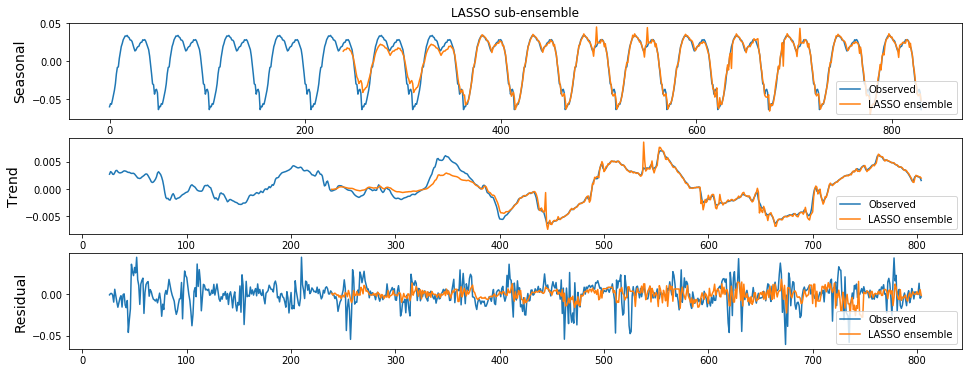

In [4]:
plt.figure(figsize=(16, 6))

# Seasonal
plt.subplot(3,1,1)
Zsea = np.array(Zd.seasonal)
ysea = yd.seasonal
ypsea = mwubox(Zsea,ysea,W,I,enable_affine,eta,2.7)
t = np.transpose(np.arange(0,y.shape[0]))
tpp = np.transpose(np.arange(0,ypsea.shape[0]))
plt.plot(t,ysea,tpp,ypsea)
plt.title('LASSO sub-ensemble')
plt.ylabel('Seasonal',FontSize=14)
plt.legend(['Observed','LASSO ensemble'], loc='lower right')

# Residual
plt.subplot(3,1,3)
Zres = np.array(Zd.resid)
yres = yd.resid
ypres = mwubox(Zres,yres,W,I,enable_affine,eta,3)
t = np.transpose(np.arange(0,y.shape[0]))
tpp = np.transpose(np.arange(0,ypres.shape[0]))
plt.plot(t,yres,tpp,ypres)
plt.ylabel('Residual',FontSize=14)
plt.legend(['Observed','LASSO ensemble'], loc='lower right')

# Trend
plt.subplot(3,1,2)
Ztre = np.array(Zd.trend)
ytre = yd.trend
yptre = mwubox(Ztre,ytre,W,I,enable_affine,eta,5)
t = np.transpose(np.arange(0,y.shape[0]))
tpp = np.transpose(np.arange(0,yptre.shape[0]))
plt.plot(t,ytre,tpp,yptre)
plt.ylabel('Trend',FontSize=14)
plt.legend(['Observed','LASSO ensemble'], loc='lower right')

plt.show()

Text(0, 0.5, 'Residual')

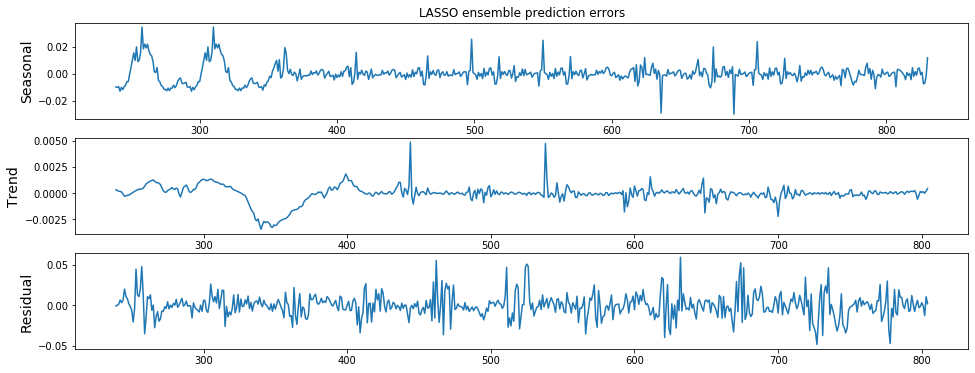

In [5]:
errsea = ypsea - ysea
errtre = yptre - ytre
errres = ypres - yres

plt.figure(figsize=(16, 6))

# Seasonal
plt.subplot(3,1,1)
plt.plot(t,errsea)
plt.title('LASSO ensemble prediction errors')
plt.ylabel('Seasonal',FontSize=14)

plt.subplot(3,1,2)
plt.plot(t,errtre)
plt.ylabel('Trend',FontSize=14)

plt.subplot(3,1,3)
plt.plot(t,errres)
plt.ylabel('Residual',FontSize=14)


## Recombination


Text(0.5, 1.0, 'Absolute value of prediction error')

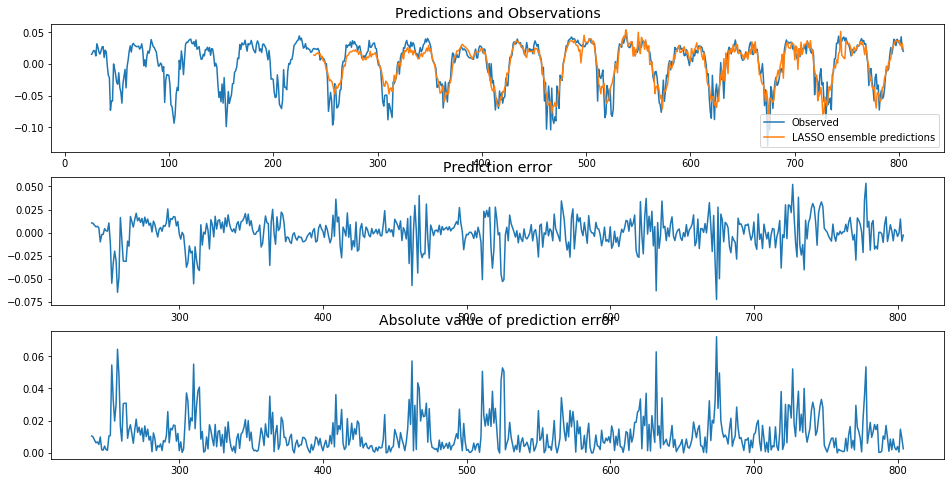

In [13]:
yp = ypsea + yptre + ypres
yo = ysea + ytre +  yres


# Plot Signals
plt.figure(figsize=(16, 8))
plt.subplot(3,1,1)
plt.plot(t,yo, t, yp)
plt.title('LASSO ensemble prediction errors')
plt.title('Predictions and Observations',FontSize=14)
plt.legend(['Observed','LASSO ensemble predictions'], loc='lower right')

# Plot errors
plt.subplot(3,1,2)
plt.plot(t,yo-yp)
plt.title('Prediction error',FontSize=14)


# Plot absolute value of error
plt.subplot(3,1,3)
plt.plot(t,np.abs(yo-yp))
plt.title('Absolute value of prediction error',FontSize=14)


## Benchmarking